In [1]:
# Import all required libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import json
from PIL import Image
from datetime import datetime
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [2]:
# Google Drive Setup

from google.colab import drive
import os

# Mount your Drive
drive.mount('/content/drive')

# Google Drive data path
DRIVE_DATA_PATH = '/content/drive/MyDrive/AID/Disease_detection_Dataset'

# Training parameters

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Model and results paths with timestamp and parameters

MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Create model name

model_name = f"plant_disease_model.h5"
MODEL_PATH = os.path.join(MODEL_DIR, model_name)
HISTORY_PATH = os.path.join(MODEL_DIR, f'training_history.json')

print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Mounted at /content/drive
Image size: (128, 128)
Batch size: 32
Epochs: 10
Learning rate: 0.0001


In [3]:
# Data loading and preprocessing
def load_and_preprocess_data():


    # Determine data source
    if 'DRIVE_DATA_PATH' in globals():
        # Use Google Drive data
        DATASET_PATH = DRIVE_DATA_PATH
        print("Using Google Drive data source")
    else:
        # Use local data
        DATASET_PATH = 'Dataset'
        print("Using local data source")

    # Gather all image paths and labels
    classes = ['Healthy', 'Disease']
    paths, labels = [], []

    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(DATASET_PATH, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','jpeg','png')):
                paths.append(os.path.join(cls_dir, fname))
                labels.append(idx)

    print(f"Found {len(paths)} images: {sum(1 for l in labels if l==0)} Healthy, {sum(1 for l in labels if l==1)} Disease")

    # Load + resize + normalize as per guide specifications
    X = np.zeros((len(paths), *IMG_SIZE, 3), dtype=np.float32)
    for i, p in enumerate(paths):
        img = Image.open(p).convert('RGB').resize(IMG_SIZE)
        # Normalize to 0-1 range as specified in guide
        X[i] = np.array(img) / 255.0

    # Convert to categorical for binary classification
    y = to_categorical(labels, num_classes=2)

    # Train/validation split (80/20 as per guide)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    print("Training shapes:", X_train.shape, y_train.shape)
    print("Validation shapes:", X_val.shape, y_val.shape)
    print("Data normalization: 0-1 range ✓")

    return X_train, X_val, y_train, y_val, classes, paths

# Load the data
X_train, X_val, y_train, y_val, classes, paths = load_and_preprocess_data()

Using Google Drive data source
Found 902 images: 458 Healthy, 444 Disease
Training shapes: (721, 128, 128, 3) (721, 2)
Validation shapes: (181, 128, 128, 3) (181, 2)
Data normalization: 0-1 range ✓


Visualizing sample images...


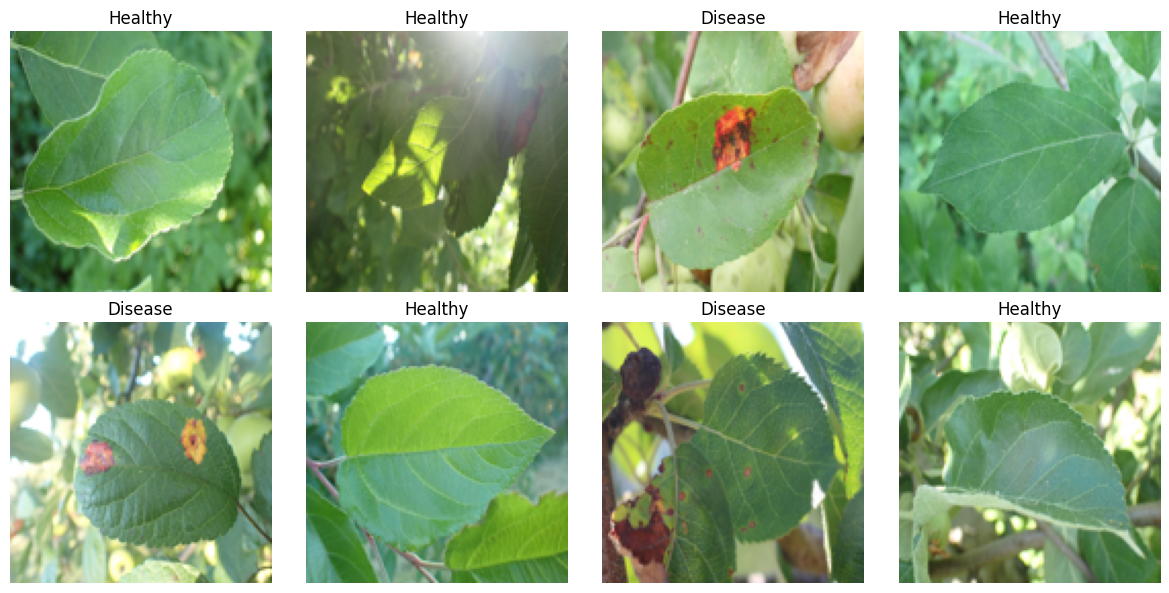

Sample images displayed - showing both Healthy and Disease classes


In [4]:
# Visualize sample images
def visualize_sample_images(X_train, y_train, classes):

    print("Visualizing sample images...")

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(len(X_train))
        ax.imshow(X_train[idx])
        label = classes[np.argmax(y_train[idx])]
        ax.set_title(f'{label}')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("Sample images displayed - showing both Healthy and Disease classes")

# Visualize sample images
visualize_sample_images(X_train, y_train, classes)

In [5]:
# Build CNN model using adam as an optimizer

def create_cnn_model():


    cnn = models.Sequential()

    # CONVOLUTIONAL BLOCK 1
    cnn.add(layers.Conv2D(filters=32, kernel_size=3, padding='same',
                          activation='relu', input_shape=[*IMG_SIZE, 3]))
    cnn.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

    # CONVOLUTIONAL BLOCK 2
    cnn.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

    # CONVOLUTIONAL BLOCK 3
    cnn.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

    # CONVOLUTIONAL BLOCK 4
    cnn.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

    # CONVOLUTIONAL BLOCK 5
    cnn.add(layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    cnn.add(layers.Conv2D(filters=512, kernel_size=3, activation='relu'))
    cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

    # DROPOUT FOR REGULARIZATION
    cnn.add(layers.Dropout(0.25))

    # FLATTEN LAYER
    cnn.add(layers.Flatten())

    # DENSE LAYER
    cnn.add(layers.Dense(units=1500, activation='relu'))

    # DROPOUT FOR REGULARIZATION
    cnn.add(layers.Dropout(0.4))

    # OUTPUT LAYER (adapted for binary classification)
    cnn.add(layers.Dense(units=2, activation='softmax'))

    # Compile model as per guide specifications
    cnn.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model architecture created following guide specifications")
    cnn.summary()

    return cnn

# Create the model
cnn = create_cnn_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture created following guide specifications


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1500)           │     3,073,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         3,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,788,726 (29.71 MB)

 Trainable params: 7,788,726 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Training process
def train_model(cnn, X_train, y_train, X_val, y_val):

    print("Starting training with guide specifications")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Image size: {IMG_SIZE}")

    # Training callbacks
    callbacks = [
        ModelCheckpoint(MODEL_PATH, save_best_only=True, verbose=1),
        EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    ]

    # Start training (TEST: 0 epochs)
    training_history = cnn.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # Save training history as per guide
    print("Testing JSON saving...")
    history_dict = {}
    for key, value in training_history.history.items():
        print(f"Key: {key}, Type: {type(value)}, Value: {value}")
        # Convert numpy arrays to regular Python lists
        if isinstance(value, np.ndarray):
            history_dict[key] = value.tolist()
        elif isinstance(value, list):
            # Convert any numpy values in lists
            history_dict[key] = [float(x) if hasattr(x, 'item') else x for x in value]
        else:
            history_dict[key] = value

    print(f"History dict to save: {history_dict}")

    try:
        with open(HISTORY_PATH, 'w') as f:
            json.dump(history_dict, f)
        print(f"✓ Training history saved to {HISTORY_PATH}")
    except Exception as e:
        print(f"✗ Error saving history: {e}")

    print(f"Best model saved to {MODEL_PATH}")
    print(f"Model filename: {os.path.basename(MODEL_PATH)}")

    return training_history

# Train the model (TEST VERSION)
training_history = train_model(cnn, X_train, y_train, X_val, y_val)

Starting training with guide specifications
Epochs: 10
Batch size: 32
Learning rate: 0.0001
Image size: (128, 128)
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4559 - loss: 0.6941
Epoch 1: val_loss improved from inf to 0.68899, saving model to models/plant_disease_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.4573 - loss: 0.6940 - val_accuracy: 0.6519 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6221 - loss: 0.6749
Epoch 2: val_loss improved from 0.68899 to 0.47062, saving model to models/plant_disease_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6248 - loss: 0.6732 - val_accuracy: 0.7624 - val_loss: 0.4706 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6317 - loss: 0.6761
Epoch 3: val_loss did not improve from 0.47062
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6308 - loss: 0.6763 - val_accuracy: 0.6740 - val_loss: 0.6559 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7390 - loss: 0.6050
Epoch 4: val_loss did not improve from 0.47062

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.7411 - loss: 0.6018 - val_accuracy: 0.7514 - val_loss: 0.5869 - learning_rate: 1.0000e-04
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7933 - loss: 0.4720
Epoch 5: val_loss improved from 0.47062 to 0.29897, saving model to models/plant_disease_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.7954 - loss: 0.4685 - val_accuracy: 0.8729 - val_loss: 0.2990 - learning_rate: 5.0000e-05
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8628 - loss: 0.3091
Epoch 6: val_loss improved from 0.29897 to 0.23549, saving model to models/plant_disease_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.8639 - loss: 0.3080 - val_accuracy: 0.8950 - val_loss: 0.2355 - learning_rate: 5.0000e-05
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9000 - loss: 0.2358
Epoch 7: val_loss improved from 0.23549 to 0.17968, saving model to models/plant_disease_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.9006 - loss: 0.2354 - val_accuracy: 0.9116 - val_loss: 0.1797 - learning_rate: 5.0000e-05
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9357 - loss: 0.1793
Epoch 8: val_loss improved from 0.17968 to 0.14680, saving model to models/plant_disease_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9359 - loss: 0.1790 - val_accuracy: 0.9282 - val_loss: 0.1468 - learning_rate: 5.0000e-05
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9491 - loss: 0.1467
Epoch 9: val_loss did not improve from 0.14680
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9492 - loss: 0.1465 - val_accuracy: 0.9116 - val_loss: 0.1656 - learning_rate: 5.0000e-05
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9626 - loss: 0.1241
Epoch 10: val_loss did not improve from 0.14680

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9627 - loss: 0.1238 - val_accuracy: 0.9116 - val_loss: 0.2106 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 8.
Testing JSON saving...
Key: accuracy, Type: <class 'list'>, Value: [0.4882108271121979, 0.6865464448928833, 0.6088765859603882, 0.7891817092895508, 0.844660222530365, 0.

Visualizing training results...


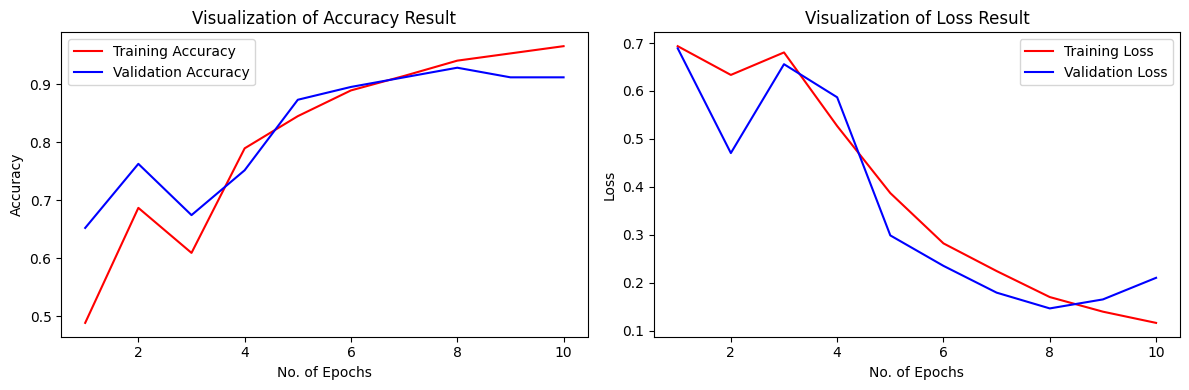

Training curves displayed as per guide specifications


In [7]:
# Visualize training results as per guide
def visualize_training_results(training_history):
    print("Visualizing training results...")

    # Check if we have any training history
    if len(training_history.history['accuracy']) == 0:
        print("No training history available (0 epochs run)")
        print("Skipping visualization - run with epochs > 0 to see training curves")
        return

    epochs = range(1, len(training_history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Visualization of Accuracy Result')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_history.history['loss'], color='red', label='Training Loss')
    plt.plot(epochs, training_history.history['val_loss'], color='blue', label='Validation Loss')
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.title('Visualization of Loss Result')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("Training curves displayed as per guide specifications")

# Visualize training results
visualize_training_results(training_history)

Training accuracy: 0.9501 (95.01%)
Validation accuracy: 0.9282 (92.82%)
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

Classification Report (as per guide)
              precision    recall  f1-score   support

     Healthy       0.88      0.99      0.93        92
     Disease       0.99      0.87      0.92        89

    accuracy                           0.93       181
   macro avg       0.94      0.93      0.93       181
weighted avg       0.93      0.93      0.93       181



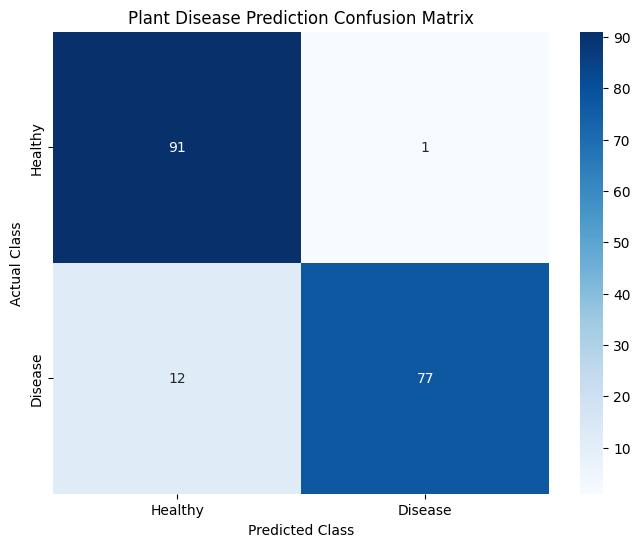

Confusion matrix displayed as per guide specifications


In [8]:
# Model evaluation as per guide specifications
def evaluate_model(cnn, X_train, y_train, X_val, y_val, classes):

    # Evaluate on training set as per guide
    train_loss, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
    print(f'Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)')

    # Evaluate on validation set as per guide
    val_loss, val_acc = cnn.evaluate(X_val, y_val, verbose=0)
    print(f'Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)')

    # Prediction on validation set as per guide
    y_pred = cnn.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)

    # Classification report as per guide
    print("\nClassification Report (as per guide)")
    print(classification_report(
        y_true_labels, y_pred_labels,
        target_names=classes
    ))

    # Confusion matrix as per guide
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Plant Disease Prediction Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("Confusion matrix displayed as per guide specifications")

    return train_acc, val_acc

# Evaluate the model
train_acc, val_acc = evaluate_model(cnn, X_train, y_train, X_val, y_val, classes)

Testing single image prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Sample prediction test
Image: /content/drive/MyDrive/AID/Disease_detection_Dataset/Healthy/801d6dcd96e48ebc.jpg
Predicted class: Healthy
Confidence: 0.5193


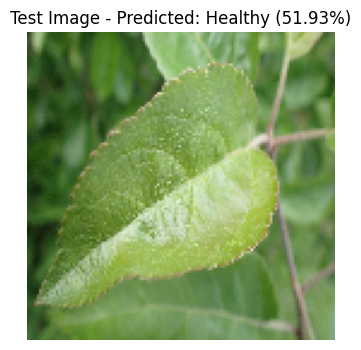

Sample prediction saved to models/sample_prediction.png

TRAINING COMPLETE - Following Guide Specifications
Model Architecture: Custom CNN (5 blocks + Dense layers)
Image Size: (128, 128)
Classes: 2 (Healthy, Disease)
Training Accuracy: 0.5076 (50.76%)
Validation Accuracy: 0.5083 (50.83%)
Model saved: models/plant_disease_model_20250801_091906_img128x128_batch32_epochs1_lr0.0001.keras
History saved: models/training_history_20250801_091906.json
Results saved in: models/

Ready for deployment!


In [ ]:
# Test single prediction as per guide
def test_single_prediction(cnn, paths, classes):
    """
    Test prediction on single image
    """
    print("Testing single image prediction...")

    def predict_single_image(image_path):
        """
        Predict on single image
        """
        # Load and preprocess image
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr])  # Convert to batch

        # Normalize as per guide
        input_arr = input_arr / 255.0

        # Make prediction
        predictions = cnn.predict(input_arr)
        result_index = np.argmax(predictions)
        predicted_class = classes[result_index]
        confidence = predictions[0][result_index]

        return predicted_class, confidence

    # Test with a sample image
    sample_image_path = paths[0]  # Use first image as test
    predicted_class, confidence = predict_single_image(sample_image_path)

    print(f"Sample prediction test")
    print(f"Image: {sample_image_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")

    # Display the test image
    plt.figure(figsize=(6, 4))
    img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.title(f'Test Image - Predicted: {predicted_class} ({confidence:.2%})')
    plt.axis('off')
    plt.savefig(os.path.join(MODEL_DIR, 'sample_prediction.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Sample prediction saved to {os.path.join(MODEL_DIR, 'sample_prediction.png')}")

# Test single prediction
test_single_prediction(cnn, paths, classes)

# Final summary
print("\n" + "=" * 80)
print("TRAINING COMPLETE - Following Guide Specifications")
print("=" * 80)
print(f"Model Architecture: Custom CNN (5 blocks + Dense layers)")
print(f"Image Size: {IMG_SIZE}")
print(f"Classes: {len(classes)} ({', '.join(classes)})")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Model saved: {MODEL_PATH}")
print(f"History saved: {HISTORY_PATH}")
print(f"Results saved in: {MODEL_DIR}/")
print("=" * 80)